# Framing in Don'Look Up (NLP Analysis of the screenplay)

## Relative or normalized Word count (no mapping)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\peter\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\peter\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\peter\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Lese Datei ein...
Erfolg! 653 Dialogblöcke gefunden.
Bereinige Text...
Berechne normalisierte Häufigkeiten...
   -> MINDY+OGLETHORPE: 2585 Wörter total
   -> KATE+YULE: 1405 Wörter total
   -> ORLEAN+JASON: 974 Wörter total
   -> ISHERWELL: 530 Wörter total
   -> Top Themen: ['comet', 'sorry', 'people', 'need', 'time']...


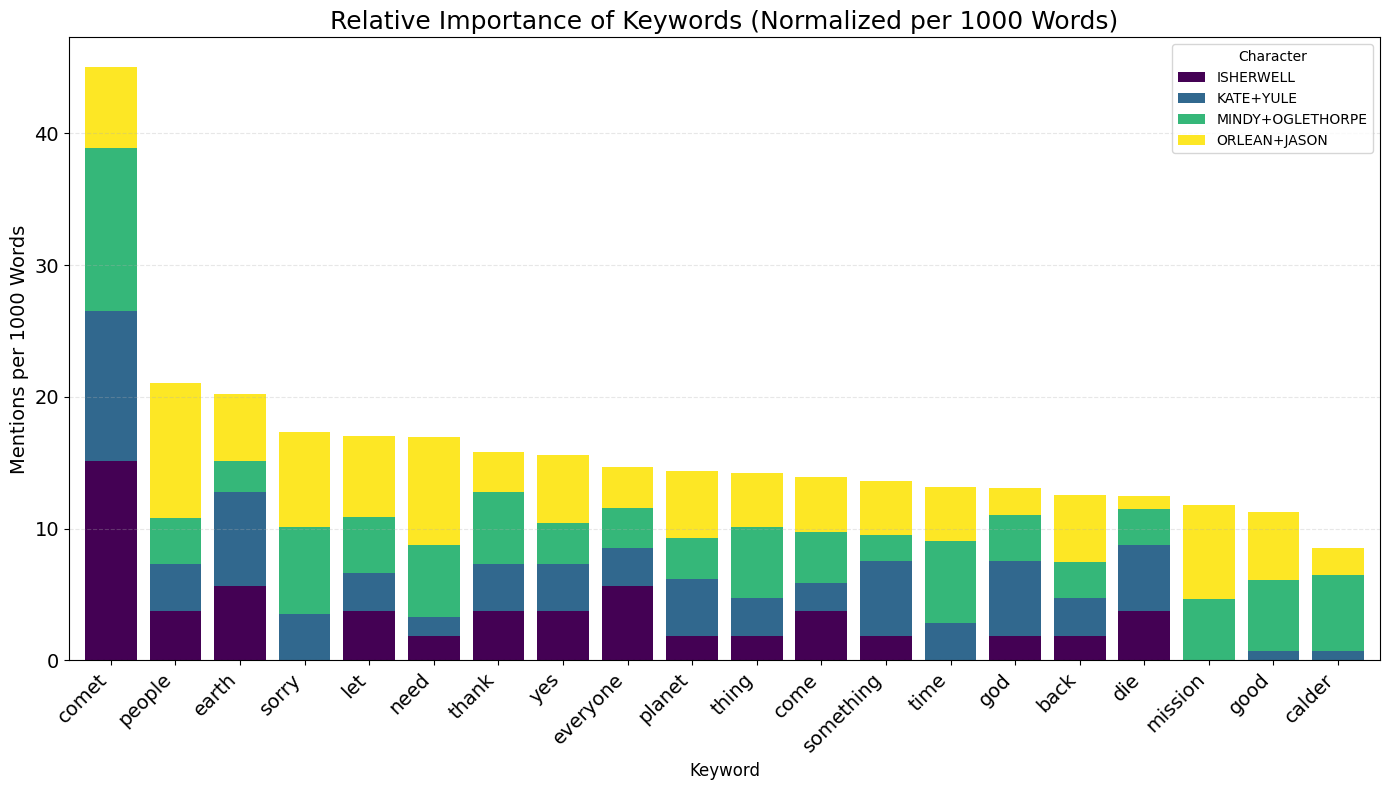

In [1]:

import re
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from collections import Counter

# ==========================================
# 1. SETUP & CONFIG
# ==========================================
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

# Konfiguration der Namen im Skript
#CHAR_CONFIG = {
#    "MINDY": ["RANDALL", "DR. MINDY", "MINDY"],
#    "KATE": ["KATE", "KATE DIBIASKY"],
#    "ORLEAN": ["PRESIDENT ORLEAN", "ORLEAN", "JANIE"],
#    "ISHERWELL": ["PETER ISHERWELL", "PETER", "ISHERWELL"]
#}

CHAR_CONFIG = {
    "MINDY+OGLETHORPE": ["MINDY", "RANDALL", "DR. MINDY", "OGLETHORPE", "DR. OGLETHORPE"],
    "KATE+YULE": ["KATE", "KATE DIBIASKY", "DIBIASKY", "YULE"],
    "ORLEAN+JASON": ["ORLEAN", "PRESIDENT ORLEAN", "JANIE", "JASON", "JASON ORLEAN"],
    "ISHERWELL": ["ISHERWELL", "PETER", "PETER ISHERWELL"]
}

# ==========================================
# 2. FUNKTIONEN (Parsing & Cleaning)
# ==========================================
def parse_screenplay_robust(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    data = []
    current_char = None
    current_buffer = []

    for line in lines:
        text = line.strip()
        if not text: continue

        # Neuer Sprecher?
        found_new_speaker = None
        for main_char, aliases in CHAR_CONFIG.items():
            for alias in aliases:
                if text.upper().startswith(alias) and len(text) < 30:
                    found_new_speaker = main_char
                    break
            if found_new_speaker: break
        
        if found_new_speaker:
            if current_char and current_buffer:
                data.append({'Character': current_char, 'Dialogue': " ".join(current_buffer)})
            current_char = found_new_speaker
            current_buffer = []
        elif current_char:
            if text.startswith("INT.") or text.startswith("EXT.") or text.startswith("CUT TO"):
                if current_buffer:
                    data.append({'Character': current_char, 'Dialogue': " ".join(current_buffer)})
                current_char = None
                current_buffer = []
            elif not (text.startswith("(") and text.endswith(")")):
                current_buffer.append(text)

    if current_char and current_buffer:
        data.append({'Character': current_char, 'Dialogue': " ".join(current_buffer)})

    return pd.DataFrame(data)

def clean_text(text):
    stop_words = set(stopwords.words('english'))
    # Erweiterte Liste von Namen und Füllwörtern zum Entfernen
    custom_ignore = [
        "randall", "mindy", "kate", "dibiasky", "janie", "orlean", "president",
        "peter", "isherwell", "jason", "oglethorpe", "brie", "evantee",
        "jack", "bremmer", "june", "phillip", "yule", "adulrel", "dr", "teddy", 
        "goddard", "bash", "sir", "ma'am",
        "int", "ext", "cut", "continued", "cont'd", "day", "night", "vo", "os",
        "know", "going", "got", "yeah", "okay", "right", "look", "think", 
        "really", "well", "like", "say", "tell", "want", "gon", "one", "get", 
        "would", "could", "us", "see"
    ]
    stop_words.update(custom_ignore)
    tokens = nltk.word_tokenize(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) > 2 and w not in stop_words]

# ==========================================
# 3. HAUPTPROGRAMM (Einlesen & Plotten)
# ==========================================
file_path = 'dont_lookup/Dont_Look_Up.txt' 

try:
    print("Lese Datei ein...")
    df = parse_screenplay_robust(file_path)
    
    print(f"Erfolg! {len(df)} Dialogblöcke gefunden.")
    print("Bereinige Text...")
    df['Tokens'] = df['Dialogue'].apply(clean_text)

    # --- NORMALISIERUNG ---
    print("Berechne normalisierte Häufigkeiten...")

    # 1. Gesamtwortzahl pro Charakter ermitteln
    char_totals = {}
    for char in CHAR_CONFIG.keys():
        all_char_tokens = [w for tokens in df[df['Character']==char]['Tokens'] for w in tokens]
        char_totals[char] = len(all_char_tokens)
        print(f"   -> {char}: {char_totals[char]} Wörter total")

    # 2. Globale Top 20 Wörter finden
    all_tokens = [w for tokens in df['Tokens'] for w in tokens]
    total_counts = Counter(all_tokens)
    top_20_words_list = [word for word, count in total_counts.most_common(20)]
    
    print(f"   -> Top Themen: {top_20_words_list[:5]}...")

    # 3. Matrix erstellen (Normalisiert auf 1000 Wörter)
    matrix_data = []
    for char in CHAR_CONFIG.keys():
        char_tokens = [w for tokens in df[df['Character']==char]['Tokens'] for w in tokens]
        char_dist = nltk.FreqDist(char_tokens)
        
        for word in top_20_words_list:
            raw_count = char_dist[word]
            total_words = char_totals[char]
            
            # Formel: (Anzahl / Total) * 1000
            if total_words > 0:
                normalized_freq = (raw_count / total_words) * 1000
            else:
                normalized_freq = 0
                
            matrix_data.append({'Word': word, 'Character': char, 'Freq': normalized_freq})

    # 4. Plotten
    df_plot = pd.DataFrame(matrix_data)
    pivot_df = df_plot.pivot(index='Word', columns='Character', values='Freq')

    # Sortieren nach Wichtigkeit
    pivot_df['Total_Weight'] = pivot_df.sum(axis=1)
    pivot_df = pivot_df.sort_values(by='Total_Weight', ascending=False)
    pivot_df = pivot_df.drop(columns=['Total_Weight'])

    # Grafik erstellen
    ax = pivot_df.plot(kind='bar', stacked=True, figsize=(14, 8), width=0.8, colormap='viridis')

    ax.tick_params(labelsize=14)
    plt.title("Relative Importance of Keywords (Normalized per 1000 Words)", fontsize=18)
    plt.ylabel("Mentions per 1000 Words", fontsize=14)
    plt.xlabel("Keyword", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Character')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"Fehler: Die Datei '{file_path}' wurde nicht gefunden.")

## Relativ or normalized Word count of screenplay (Synomyme zusammengefasst eg earth, planet and globe => earth)

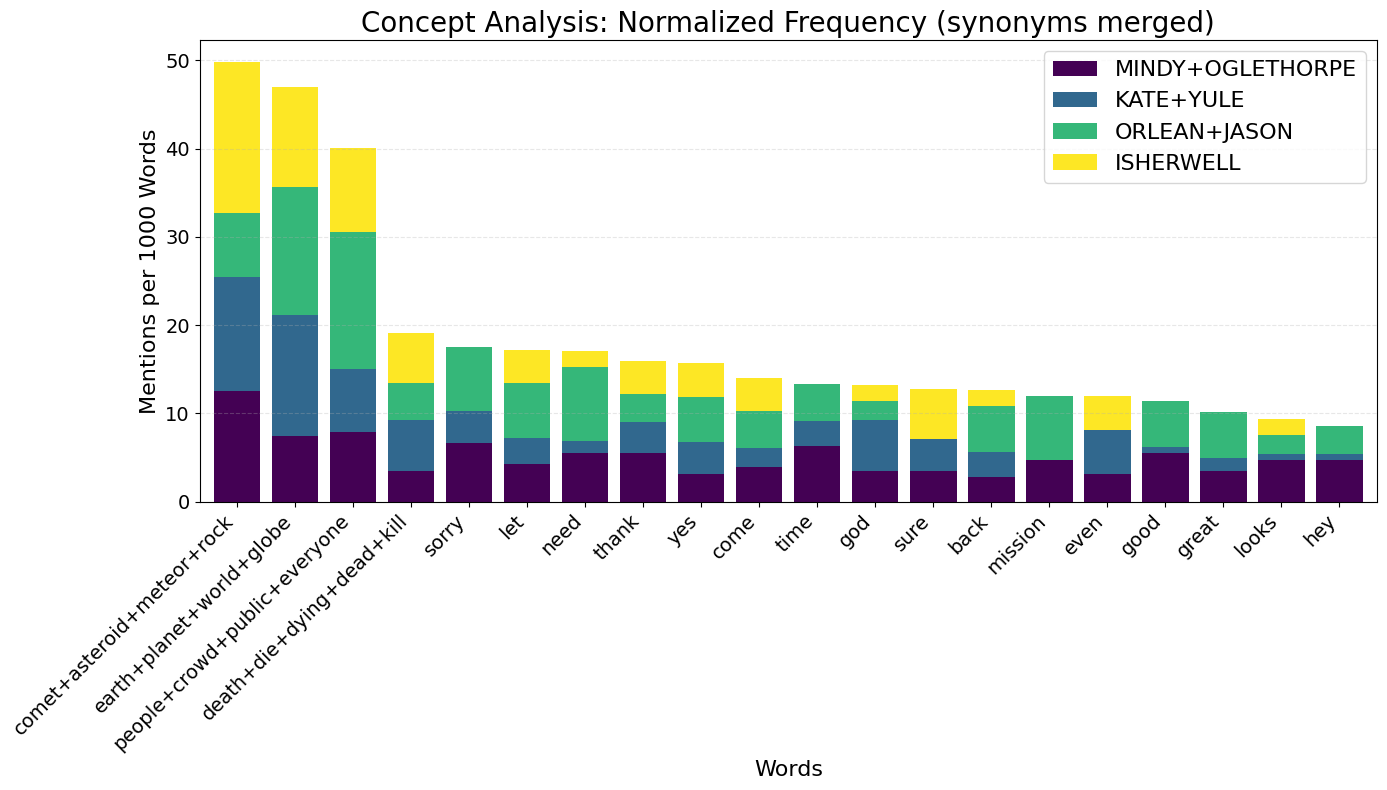

In [2]:
import re
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from collections import Counter

# ==========================================
# 1. SETUP & CONFIG
# ==========================================
# Sicherstellen, dass notwendige NLTK-Daten da sind
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Die Reihenfolge hier bestimmt die Reihenfolge in der Legende!
CHAR_CONFIG = {
    "MINDY+OGLETHORPE": ["MINDY", "RANDALL", "DR. MINDY", "OGLETHORPE", "DR. OGLETHORPE"],
    "KATE+YULE": ["KATE", "KATE DIBIASKY", "DIBIASKY", "YULE"],
    "ORLEAN+JASON": ["ORLEAN", "PRESIDENT ORLEAN", "JANIE", "JASON", "JASON ORLEAN"],
    "ISHERWELL": ["ISHERWELL", "PETER", "PETER ISHERWELL"]
}

# ==========================================
# 2. CLEANING MIT "CONCEPT MAPPING"
# ==========================================
def clean_text(text):
    stop_words = set(stopwords.words('english'))
    
    # Deine Stopwords
    custom_ignore = [
        "randall", "mindy", "kate", "dibiasky", "janie", "orlean", "president",
        "peter", "isherwell", "jason", "oglethorpe", "brie", "evantee",
        "jack", "bremmer", "june", "phillip", "yule", "adulrel", "dr", "teddy", 
        "goddard", "bash", "sir", "ma'am", "calder",
        "int", "ext", "cut", "continued", "cont'd", "day", "night", "vo", "os",
        "know", "going", "got", "yeah", "okay", "right", "look", "think", 
        "really", "well", "like", "say", "tell", "want", "gon", "one", "get", 
        "would", "could", "us", "see", "thing", "something"
    ]
    stop_words.update(custom_ignore)
    
    tokens = nltk.word_tokenize(text.lower())
    
    cleaned_tokens = []
    for w in tokens:
        if w.isalpha() and len(w) > 2 and w not in stop_words:
            
            # --- MAPPING: Begriffe vereinfachen ---
            # Das Wort, das hier 'append' wird, erscheint im Diagramm.
            # "planet" wird zu "earth" gezählt.
            if w in ["earth","planet", "world", "globe"]:
                cleaned_tokens.append("earth+planet+world+globe") 
            
            elif w in ["money","dollar","dollars", "cash", "funds"]:
                cleaned_tokens.append("money+dollars+cash+funds")

            elif w in ["people","crowd","crowds","public", "everyone"]:
                cleaned_tokens.append("people+crowd+public+everyone")
            
            elif w in ["DIE","die","death", "died", "dying", "dead", "kill"]:
                cleaned_tokens.append("death+die+dying+dead+kill")
                
            #elif w in ["comet", "asteroid", "meteor", "rock", "object", "projectile"]:
            elif w in ["comet", "asteroid", "meteor", "rock", "object"]:
                cleaned_tokens.append("comet+asteroid+meteor+rock")                
                
            else:
                cleaned_tokens.append(w)
                
    return cleaned_tokens

# ==========================================
# 3. AUSFÜHRUNG & PLOT
# ==========================================
file_path = 'dont_lookup/Dont_Look_Up.txt' 

try:
    # --- Parsing ---
    # (Wir gehen davon aus, dass 'parse_screenplay_robust' im Notebook definiert ist)
    if 'parse_screenplay_robust' not in locals():
         print("Bitte definiere zuerst die Funktion 'parse_screenplay_robust'!")
    else:
        df = parse_screenplay_robust(file_path) 
        df['Tokens'] = df['Dialogue'].apply(clean_text)

        # --- Normalisierungs-Basis berechnen ---
        char_totals = {}
        for char in CHAR_CONFIG.keys():
            all_char_tokens = [w for tokens in df[df['Character']==char]['Tokens'] for w in tokens]
            char_totals[char] = len(all_char_tokens)

        # --- Top 20 Konzepte finden ---
        all_tokens = [w for tokens in df['Tokens'] for w in tokens]
        total_counts = Counter(all_tokens)
        top_20_words_list = [word for word, count in total_counts.most_common(20)]
        
        # --- Matrix bauen ---
        matrix_data = []
        for char in CHAR_CONFIG.keys():
            char_tokens = [w for tokens in df[df['Character']==char]['Tokens'] for w in tokens]
            char_dist = nltk.FreqDist(char_tokens)
            
            for word in top_20_words_list:
                raw_count = char_dist[word]
                total_words = char_totals[char]
                # Frequenz pro 1000 Wörter
                normalized_freq = (raw_count / total_words) * 1000 if total_words > 0 else 0
                matrix_data.append({'Word': word, 'Character': char, 'Freq': normalized_freq})

        # --- Plot-Vorbereitung ---
        df_plot = pd.DataFrame(matrix_data)
        pivot_df = df_plot.pivot(index='Word', columns='Character', values='Freq')

        # Reihenfolge der Legende erzwingen (wie in CHAR_CONFIG definiert)
        desired_order = list(CHAR_CONFIG.keys()) 
        pivot_df = pivot_df.reindex(columns=desired_order)

        # Sortierung der X-Achse nach Gesamt-Häufigkeit
        pivot_df['Total_Weight'] = pivot_df.sum(axis=1)
        pivot_df = pivot_df.sort_values(by='Total_Weight', ascending=False)
        pivot_df = pivot_df.drop(columns=['Total_Weight'])

        # --- Plotten ---
        # HIER GEÄNDERT: colormap='viridis' für die ursprüngliche Farbgebung
        ax = pivot_df.plot(kind='bar', stacked=True, figsize=(14, 8), width=0.8, colormap='viridis')
        
        plt.title("Concept Analysis: Normalized Frequency (synonyms merged)", fontsize=20)
        plt.ylabel("Mentions per 1000 Words", fontsize=16)
        plt.xlabel("Words", fontsize=16)
        plt.xticks(rotation=45, ha='right')
        
        # Legende
        plt.legend(title='', loc='upper right', fontsize=16)

        ax.tick_params(labelsize=14)
        plt.grid(axis='y', linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.savefig("Freq_Words.png", dpi=300, bbox_inches='tight')
        plt.show()

except FileNotFoundError:
    print(f"Datei nicht gefunden: {file_path}")
except Exception as e:
    print(f"Ein Fehler ist aufgetreten: {e}")

## Data source summary

--- DATA CHARACTERISTICS ---
                  Dialogue Blocks  Total Words (Cleaned)  \
Character                                                  
MINDY+OGLETHORPE              302                   2551   
KATE+YULE                     181                   1392   
ORLEAN+JASON                  132                    964   
ISHERWELL                      38                    528   

                  Avg. Words per Block  Share of Voice (%)  
Character                                                   
MINDY+OGLETHORPE                   8.4                46.9  
KATE+YULE                          7.7                25.6  
ORLEAN+JASON                       7.3                17.7  
ISHERWELL                         13.9                 9.7  


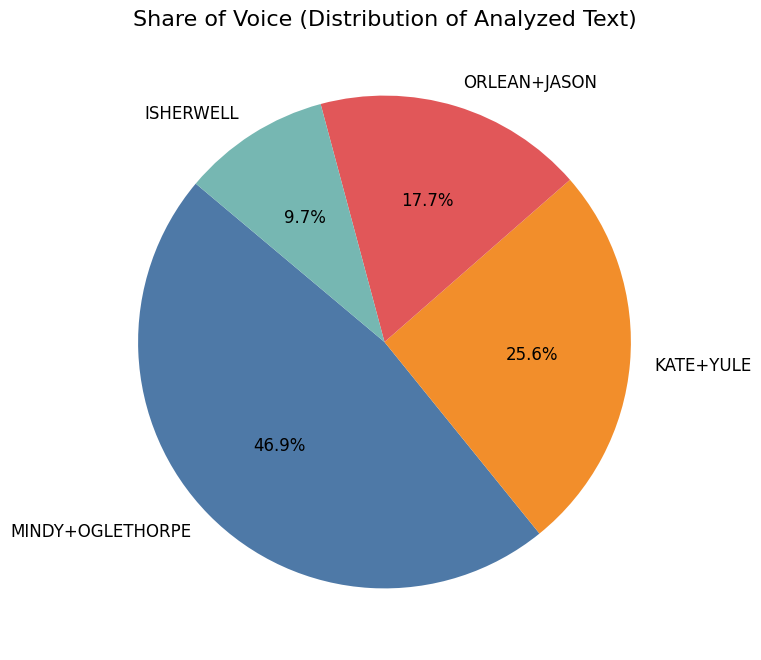

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Wir gehen davon aus, dass 'df' (die Tabelle mit Tokens) aus dem vorigen Schritt noch da ist.
# Falls nicht, führe bitte den großen Block von vorhin ("parse_screenplay_robust") nochmal aus.

try:
    print("--- DATA CHARACTERISTICS ---")
    
    stats_data = []
    
    for char in CHAR_CONFIG.keys():
        # Filter auf den Charakter
        char_df = df[df['Character'] == char]
        
        # 1. Anzahl der Sprechakte (Wie oft darf er/sie reden?)
        num_blocks = len(char_df)
        
        # 2. Alle Wörter (Tokens) sammeln (Wie viel sagt er/sie insgesamt?)
        # Wir nehmen hier die 'Tokens' (bereinigt), man könnte auch Roh-Wörter zählen.
        all_tokens = [w for tokens in char_df['Tokens'] for w in tokens]
        num_words = len(all_tokens)
        
        # 3. Durchschnittliche Länge pro Sprechakt
        avg_len = round(num_words / num_blocks, 1) if num_blocks > 0 else 0
        
        stats_data.append({
            "Character": char,
            "Dialogue Blocks": num_blocks,
            "Total Words (Cleaned)": num_words,
            "Avg. Words per Block": avg_len
        })
    
    # Tabelle erstellen
    stats_df = pd.DataFrame(stats_data).set_index("Character")
    
    # Prozentanteil berechnen (Share of Voice)
    total_corpus_words = stats_df["Total Words (Cleaned)"].sum()
    stats_df["Share of Voice (%)"] = round((stats_df["Total Words (Cleaned)"] / total_corpus_words) * 100, 1)
    
    # Sortieren nach Wortanzahl
    stats_df = stats_df.sort_values(by="Total Words (Cleaned)", ascending=False)
    
    print(stats_df)
    
    # --- VISUALISIERUNG: KUCHENDIAGRAMM ---
    plt.figure(figsize=(8, 8))
    # Wir nutzen eine etwas schönere Farbpalette
    colors = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2'] 
    
    plt.pie(stats_df["Total Words (Cleaned)"], 
            labels=stats_df.index, 
            autopct='%1.1f%%', 
            startangle=140,
            colors=colors,
            textprops={'fontsize': 12})
            
    plt.title("Share of Voice (Distribution of Analyzed Text)", fontsize=16)
    plt.show()

except NameError:
    print("Fehler: Die Variable 'df' fehlt. Bitte führe den Haupt-Codeblock von vorhin erst aus.")

## Verteilung aller Sprecher

Analysiere gesamte Sprecher-Struktur...
Insgesamt gefundene Sprech-Rollen: 135

TOP 10 SPRECHER (Anzahl der Redebeiträge):
                  Count
RANDALL             232
KATE                139
PRESIDENT ORLEAN     74
DR. OGLETHORPE       72
JASON                56
BRIE EVANTEE         51
PETER ISHERWELL      37
YULE                 33
JACK BREMMER         32
JUNE                 30


C:\Users\peter\AppData\Local\Temp\ipykernel_10756\2527301837.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20['Count'], y=top_20.index, palette="viridis")


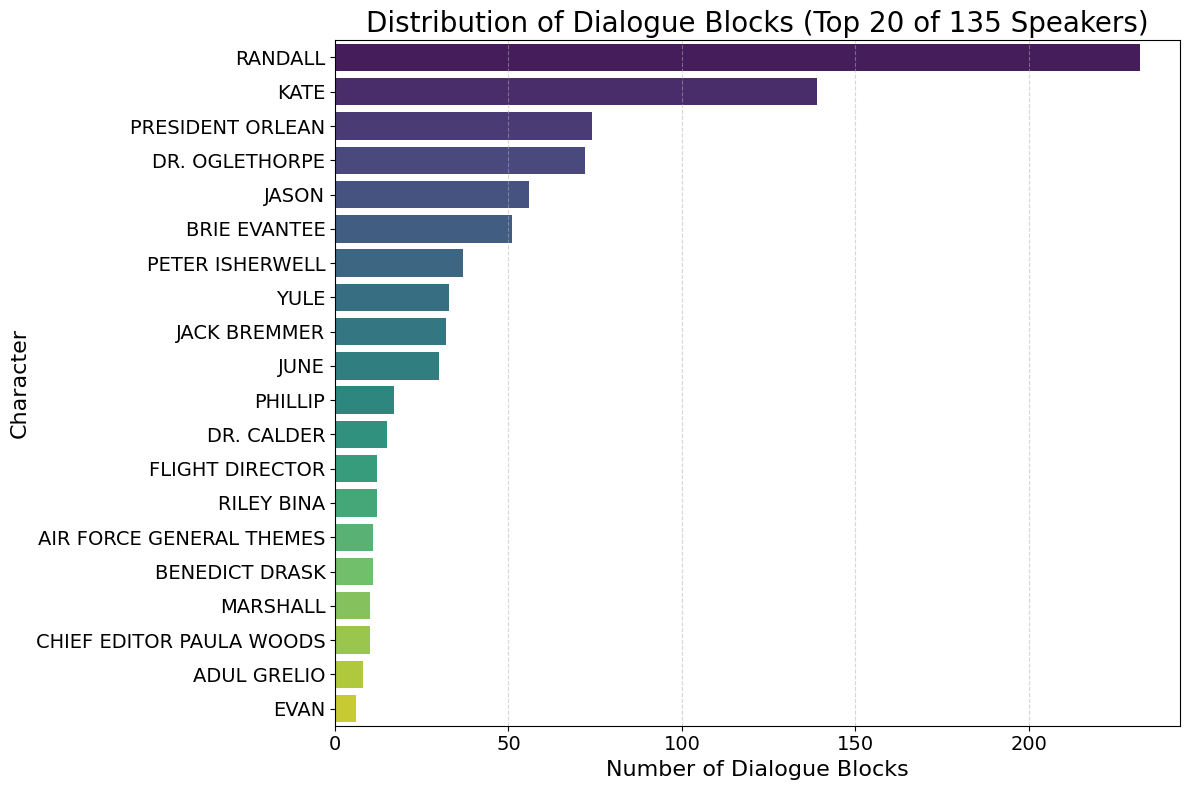

In [4]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# DATEIPFAD ANPASSEN
file_path = 'dont_lookup/Dont_Look_Up.txt' 

def analyze_all_speakers(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    speaker_counts = Counter()
    
    # Dinge, die im Drehbuch großgeschrieben sind, aber KEINE Sprecher sind
    blacklist = [
        "CUT TO", "FADE IN", "FADE OUT", "INT.", "EXT.", "THE END", 
        "CONTINUED", "OMITTED", "VOICE (OVER)", "TITLE", "CREDITS",
        "WRITTEN BY", "STORY BY", "DON'T LOOK UP", "BLACK.", "OPEN ON:",
        "JUMP CUT", "TIME JUMP"
    ]

    for line in lines:
        stripped = line.strip()
        
        # Kriterien für einen Sprecher-Namen im Skript:
        # 1. Nicht leer
        # 2. Komplett GROSSGESCHRIEBEN (isupper)
        # 3. Keine Zahlen (keine Szenennummern wie "12A")
        # 4. Nicht zu lang (Szenenbeschreibungen sind oft lang)
        if stripped and stripped.isupper() and len(stripped) < 35 and not any(char.isdigit() for char in stripped):
            
            # Bereinigung: "MINDY (CONT'D)" -> "MINDY"
            # Wir entfernen alles in Klammern
            clean_name = re.sub(r'\s*\(.*?\)', '', stripped).strip()
            
            # Bereinigung: Satzzeichen weg (falls "MINDY:" da steht)
            clean_name = clean_name.replace(':', '')

            # Check gegen Blacklist
            is_valid = True
            for bad_word in blacklist:
                if bad_word in clean_name:
                    is_valid = False
                    break
            
            if is_valid and len(clean_name) > 1: # Einbuchstabige Namen ignorieren
                speaker_counts[clean_name] += 1

    return speaker_counts

# --- AUSFÜHRUNG ---
try:
    print("Analysiere gesamte Sprecher-Struktur...")
    counts = analyze_all_speakers(file_path)
    
    # DataFrame erstellen
    df_speakers = pd.DataFrame.from_dict(counts, orient='index', columns=['Count'])
    df_speakers = df_speakers.sort_values(by='Count', ascending=False)
    
    print(f"Insgesamt gefundene Sprech-Rollen: {len(df_speakers)}")
    print("\nTOP 10 SPRECHER (Anzahl der Redebeiträge):")
    print(df_speakers.head(10))

    # --- VISUALISIERUNG (TOP 20) ---
    plt.figure(figsize=(12, 8))
    
    # Nur die Top 20 plotten
    top_20 = df_speakers.head(20)
    
    sns.barplot(x=top_20['Count'], y=top_20.index, palette="viridis")
    
    plt.title(f"Distribution of Dialogue Blocks (Top 20 of {len(df_speakers)} Speakers)", fontsize=20)
    plt.xlabel("Number of Dialogue Blocks", fontsize=16)
    plt.ylabel("Character", fontsize=16)
    plt.xticks(fontsize=14) 
    plt.yticks(fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("Freq_Speaker.png", dpi=300, bbox_inches='tight')
    plt.show()

except FileNotFoundError:
    print("Datei nicht gefunden.")

# Neue kombinierte Version (Kosinus-Ähnlichkeit und Weltbild-Scan) und 4 Weltbilder

Lade Sprachmodell (das kann kurz dauern)...

Verarbeite Texte mit Spacy...
   -> SCIENCE (Rationality) (9852 Wörter)
   -> ACTIVISM (Truth/Panic) (4891 Wörter)
   -> POPULISM (Image) (3752 Wörter)
   -> CAPITALISM (Profit) (1426 Wörter)

--- KOSINUS-ÄHNLICHKEIT (Ausschnitt) ---
                        SCIENCE (Rationality)  ACTIVISM (Truth/Panic)  \
SCIENCE (Rationality)                1.000000                0.999380   
ACTIVISM (Truth/Panic)               0.999380                1.000000   
POPULISM (Image)                     0.998864                0.999141   
CAPITALISM (Profit)                  0.994386                0.995269   

                        POPULISM (Image)  CAPITALISM (Profit)  
SCIENCE (Rationality)           0.998864             0.994386  
ACTIVISM (Truth/Panic)          0.999141             0.995269  
POPULISM (Image)                1.000000             0.994982  
CAPITALISM (Profit)             0.994982             1.000000  

--- WELTBILD-SCAN (Werte pro 1000 

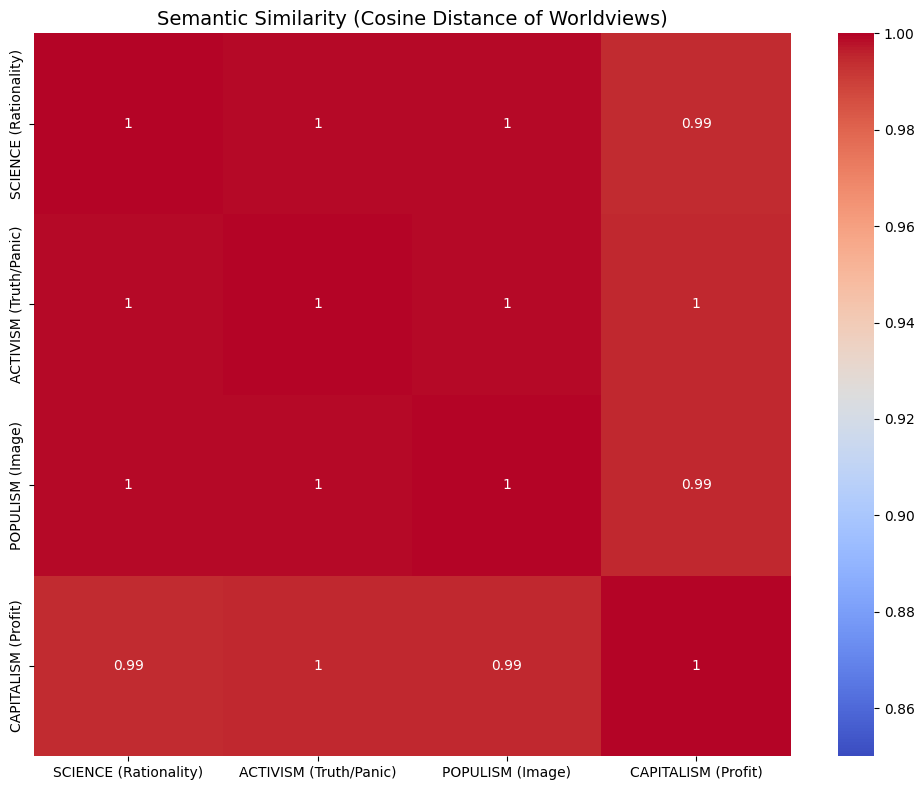

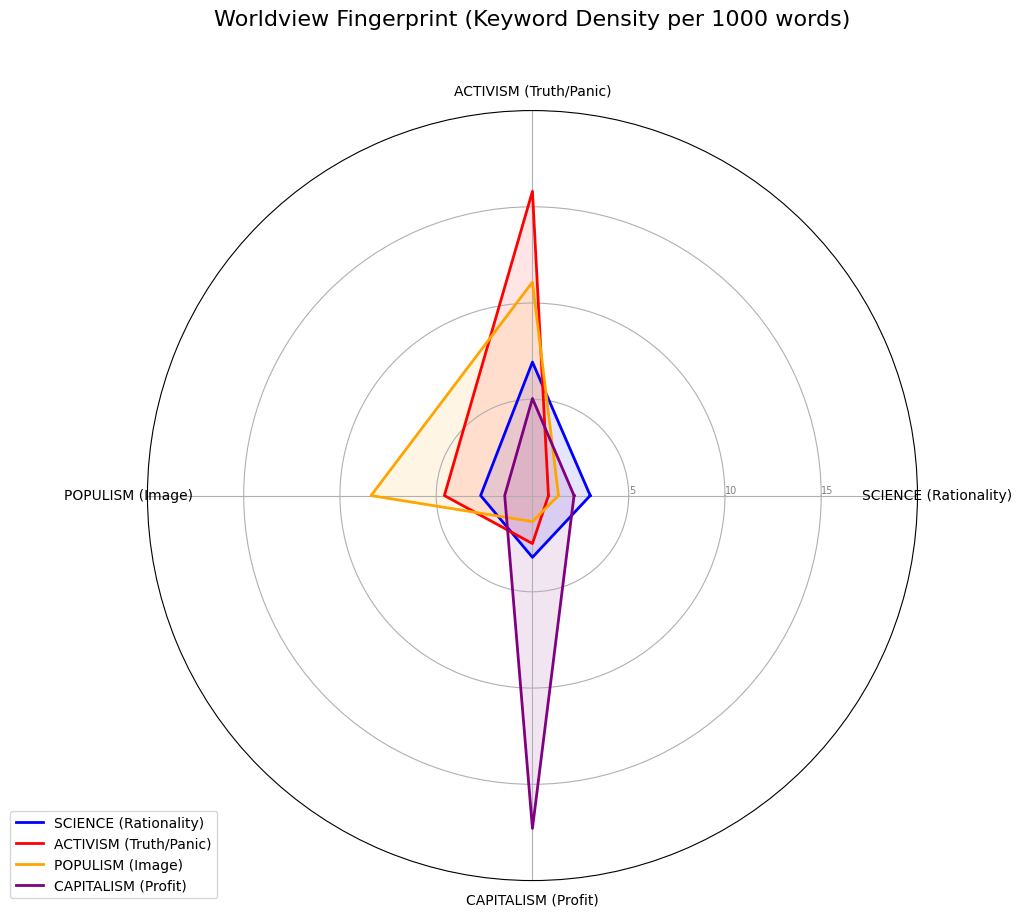

In [6]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from math import pi

# ==========================================
# 1. SETUP & MODEL LOADING
# ==========================================
print("Lade Sprachmodell (das kann kurz dauern)...")
try:
    # Wir brauchen das Medium-Modell für Vektoren (md)
    nlp = spacy.load("en_core_web_md")
except OSError:
    print("FEHLER: Bitte lade das Modell erst herunter:")
    print("Run: python -m spacy download en_core_web_md")
    exit()

# DEFINITION DER 4 WELTBILD-GRUPPEN (Die "Cluster")
# Wir fassen Charaktere zusammen, um stärkere Signale zu bekommen.
WORLDVIEW_GROUPS = {
    "SCIENCE (Rationality)": ["MINDY", "RANDALL", "DR. MINDY", "OGLETHORPE", "DR. OGLETHORPE"],
    "ACTIVISM (Truth/Panic)": ["KATE", "KATE DIBIASKY", "YULE"],
    "POPULISM (Image)": ["ORLEAN", "PRESIDENT ORLEAN", "JANIE", "JASON", "JASON ORLEAN"],
    "CAPITALISM (Profit)": ["ISHERWELL", "PETER", "PETER ISHERWELL"]
}

# KEYWORDS FÜR DEN SCAN (Hier suchen wir aktiv nach Begriffen)


KEYWORDS = {
    "SCIENCE (Rationality)": [
        "data", "math", "mathematics", "science", "scientific", "number", "numbers", 
        "peer-review", "trajectory", "telescope", "calculations", "accuracy", 
        "fact", "facts", "physics", "sigma", "orbit", "probability", "certainty"
    ],
    "ACTIVISM (Truth/Panic)": [
        # HIER ENTFERNT: "we", "us", "people", "everyone", "world" (zu allgemein)
        "truth", "die", "dying", "kill", "killed", "planet", "earth", 
        "emergency", "scream", "shit", "fuck", "fucking", "real", "alive", 
        "terrifying", "stop", "end", "scared", "crying", "insane"
    ],
    "POPULISM (Image)": [
        # HIER ENTFERNT: "love", "cool", "couple"
        "poll", "polls", "vote", "election", "trending", "celebrity", "media", 
        "rating", "ratings", "image", "crowd", "presidential", "mom", "hero", 
        "likes", "subscribers", "news", "tv", "famous"
    ],
    "CAPITALISM (Profit)": [
        # HIER ENTFERNT: "business", "economy" (sagt auch die Präsidentin oft)
        "dollar", "dollars", "trillion", "asset", "assets", "stock", "stocks", 
        "growth", "rich", "acquire", "evolution", "executive", "opportunity", 
        "liif", "bash", "buy", "buying", "mineral", "minerals", "gold"
    ]
}

# ==========================================
# 2. DATA PARSING (Robust .txt method)
# ==========================================
def parse_screenplay_grouped(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    # Dictionary zum Speichern des gesamten Textes pro Gruppe
    # z.B. group_texts["SCIENCE"] = "we have to calculate the orbit..."
    group_texts = {key: [] for key in WORLDVIEW_GROUPS.keys()}
    
    current_group = None
    
    # Flatten alias list for easier searching
    # mapping: "RANDALL" -> "SCIENCE"
    alias_to_group = {}
    for group, aliases in WORLDVIEW_GROUPS.items():
        for alias in aliases:
            alias_to_group[alias] = group

    for line in lines:
        text = line.strip()
        if not text: continue

        # 1. Check: Ist das ein Charakter-Name?
        found_group = None
        # Wir prüfen, ob die Zeile mit einem bekannten Alias beginnt (und kurz ist)
        for alias, group in alias_to_group.items():
            if text.upper().startswith(alias.upper()) and len(text) < 30:
                found_group = group
                break
        
        if found_group:
            current_group = found_group
        
        # 2. Wenn wir einen aktiven Sprecher haben, sammeln wir den Text
        elif current_group:
            # Szenenanweisungen ignorieren
            if not (text.startswith("INT.") or text.startswith("EXT.") or text.startswith("CUT TO")):
                # Regieanweisungen in Klammern ignorieren
                if not (text.startswith("(") and text.endswith(")")):
                    group_texts[current_group].append(text)

    # Zusammenfügen zu einem langen String pro Gruppe
    return {k: " ".join(v) for k, v in group_texts.items()}

# ==========================================
# 3. ANALYSE (Similarity & Keywords)
# ==========================================
def analyze_worldviews(text_data):
    results_similarity = {}
    results_keywords = {}
    
    docs = {}
    
    print("\nVerarbeite Texte mit Spacy...")
    for group, text in text_data.items():
        print(f"   -> {group} ({len(text.split())} Wörter)")
        if len(text) == 0:
            print("WARNUNG: Kein Text gefunden!")
            continue
        # Wir limitieren auf 100k Zeichen pro Gruppe für Performance, falls nötig
        docs[group] = nlp(text[:200000])

    # A. COSINE SIMILARITY MATRIX
    # Wir vergleichen jeden mit jedem
    groups = list(docs.keys())
    sim_matrix = pd.DataFrame(index=groups, columns=groups, dtype=float)
    
    for g1 in groups:
        for g2 in groups:
            sim = docs[g1].similarity(docs[g2])
            sim_matrix.loc[g1, g2] = sim

    # B. KEYWORD DENSITY SCAN
    # Wir zählen Lemmata (Grundformen), also "died" -> "die"
    for group, doc in docs.items():
        counts = {k: 0 for k in KEYWORDS.keys()}
        tokens = [t.lemma_.lower() for t in doc if t.is_alpha]
        total_words = len(tokens)
        
        if total_words == 0: continue

        for t in tokens:
            for category, word_list in KEYWORDS.items():
                if t in word_list:
                    counts[category] += 1
        
        # Normalisierung auf 1000 Wörter
        results_keywords[group] = {k: (v / total_words) * 1000 for k, v in counts.items()}

    return sim_matrix, results_keywords

# ==========================================
# 4. VISUALISIERUNG
# ==========================================
def plot_results(sim_matrix, keyword_data):
    
    # PLOT 1: HEATMAP (Wer versteht wen?)
    plt.figure(figsize=(10, 8))
    sns.heatmap(sim_matrix, annot=True, cmap="coolwarm", vmin=0.85, vmax=1.0)
    plt.title("Semantic Similarity (Cosine Distance of Worldviews)", fontsize=14)
    plt.tight_layout()
    plt.show()

    # PLOT 2: RADAR CHART (Das Weltbild)
    # Daten vorbereiten
    labels = list(KEYWORDS.keys())
    num_vars = len(labels)
    
    # Winkel berechnen
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1] # Kreis schließen
    
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)
    
    # Achsen beschriften
    plt.xticks(angles[:-1], labels, color='black', size=10)
    
    # Y-Achsen Labels
    ax.set_rlabel_position(0)
    plt.yticks([5, 10, 15], ["5", "10", "15"], color="grey", size=7)
    plt.ylim(0, 20) # Skala anpassen je nach Ergebnis (evtl. erhöhen auf 30)

    # Farben für die 4 Gruppen
    colors = ['blue', 'red', 'orange', 'purple']
    
    for i, (group, data) in enumerate(keyword_data.items()):
        values = list(data.values())
        values += values[:1] # Kreis schließen
        
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=group, color=colors[i])
        ax.fill(angles, values, color=colors[i], alpha=0.1)

    plt.title("Worldview Fingerprint (Keyword Density per 1000 words)", size=16, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

# ==========================================
# MAIN EXECUTION
# ==========================================
file_path = 'dont_lookup/Dont_Look_Up.txt'  # PFAD ANPASSEN!

try:
    # 1. Text laden & gruppieren
    grouped_text = parse_screenplay_grouped(file_path)
    
    # 2. Analysieren
    sim_matrix, keyword_results = analyze_worldviews(grouped_text)
    
    # 3. Ergebnisse Textausgabe
    print("\n--- KOSINUS-ÄHNLICHKEIT (Ausschnitt) ---")
    print(sim_matrix)
    
    print("\n--- WELTBILD-SCAN (Werte pro 1000 Wörter) ---")
    for group, scores in keyword_results.items():
        print(f"{group}: {scores}")

    # 4. Grafiken
    plot_results(sim_matrix, keyword_results)

except FileNotFoundError:
    print(f"Datei nicht gefunden: {file_path}")

## Word Cloud

Generiere konsistente Wortwolken...


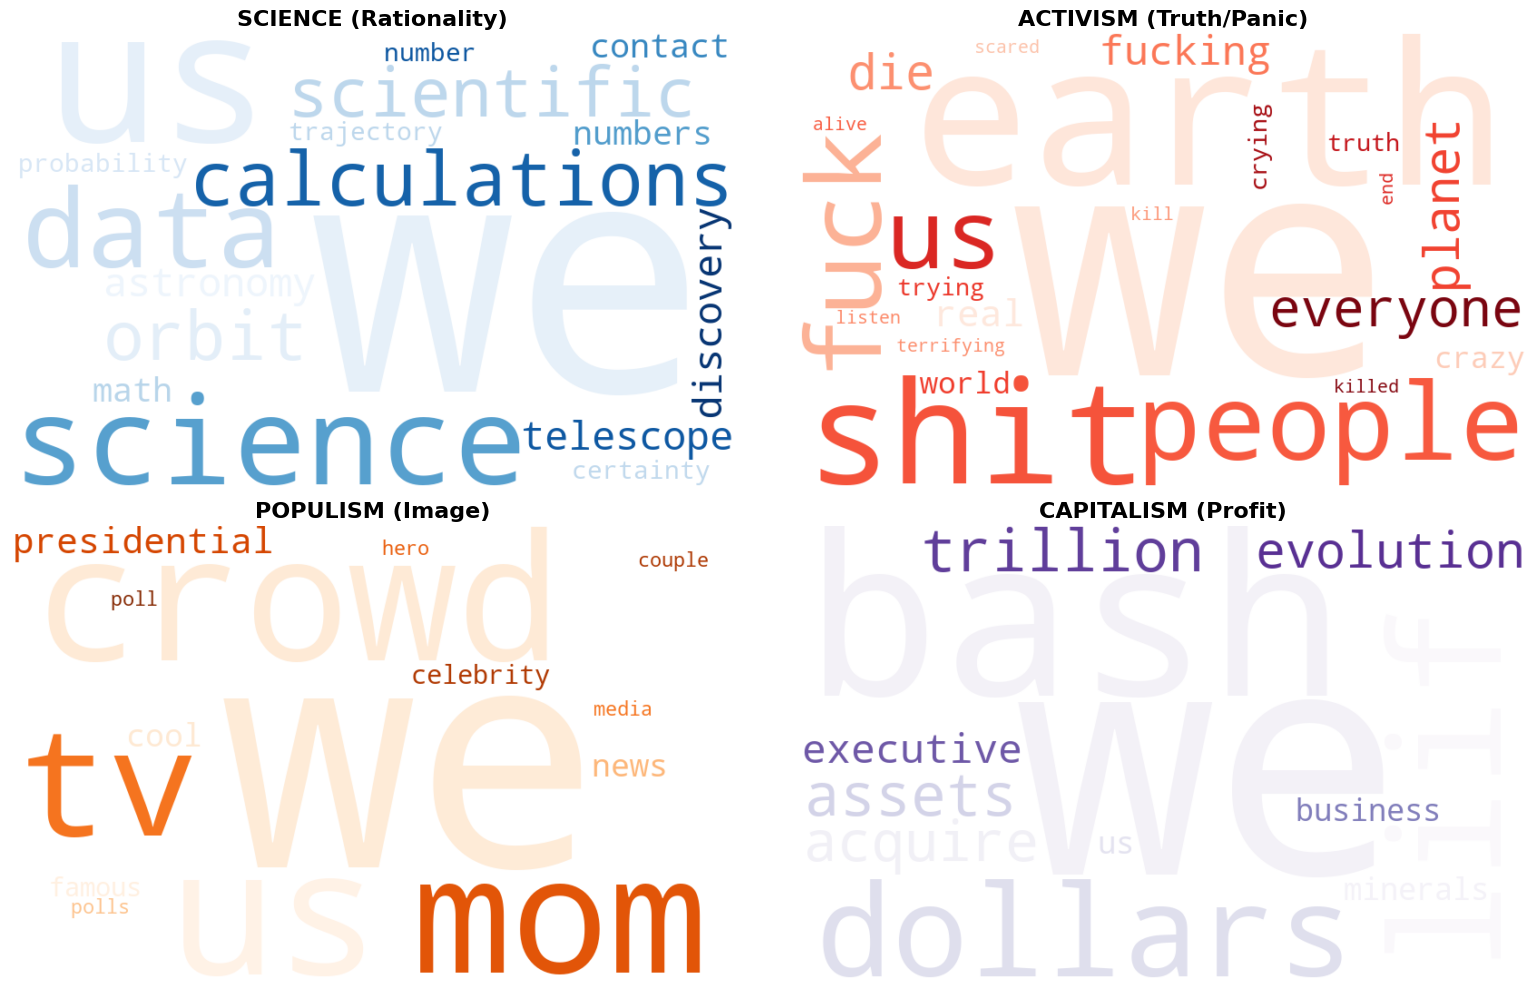

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import re
from wordcloud import WordCloud

# ==========================================
# 1. SETUP: KONSISTENTE KEYWORDS (Identisch zum Radar-Chart)
# ==========================================
# Das ist exakt die Liste, die wir für das Radar-Chart genutzt haben.
KEYWORDS = {
    "SCIENCE (Rationality)": [
        "data", "math", "mathematics", "science", "scientific", "number", "numbers", 
        "peer-review", "trajectory", "telescope", "calculation", "calculations", 
        "accuracy", "fact", "facts", "physics", "sigma", "astronomy", 
        "discovery", "object", "orbit", "probability", "contact", "certainty", "we", "us"
    ],
    "ACTIVISM (Truth/Panic)": [
        "truth", "die", "dying", "kill", "killed", "planet", "earth", "world",
        "emergency", "scream", "shit", "fuck", "fucking", "real", "alive", 
        "terrifying", "stop", "end", "scared", "listen", "crying", "crazy",
        "people", "everyone", "trying", "joke", "nuts", "insane", "we", "us"
    ],
    "POPULISM (Image)": [
        "poll", "polls", "vote", "election", "trending", "celebrity", "media", 
        "rating", "ratings", "image", "crowd", "presidential", "mom", "hero", 
        "likes", "subscribers", "news", "tv", "famous", "cool", "love", "couple", "we", "us"
    ],
    "CAPITALISM (Profit)": [
        "dollar", "dollars", "trillion", "asset", "assets", "stock", "stocks", 
        "growth", "rich", "acquire", "evolution", "executive", "opportunity", 
        "liif", "bash", "buy", "buying", "mineral", "minerals", "gold", "job", "jobs",
        "business", "economy", "rights", "we", "us"
    ]
}

COLOR_MAPS = {
    "SCIENCE (Rationality)": "Blues",
    "ACTIVISM (Truth/Panic)": "Reds",
    "POPULISM (Image)": "Oranges",
    "CAPITALISM (Profit)": "Purples"
}

# ==========================================
# 2. CHECK & RELOAD (Sicherheitshalber)
# ==========================================
# Falls du das Skript einzeln ausführst, stellen wir sicher, dass Text da ist.
if 'grouped_text' not in locals() or not grouped_text:
    print("Variable 'grouped_text' nicht gefunden. Bitte führe erst den Parsing-Block aus!")
    # Hier könnte man theoretisch force_reparse() aufrufen, wenn definiert.

# ==========================================
# 3. PLOTTEN
# ==========================================
def count_exact_keywords_robust(text, target_keywords):
    text_lower = text.lower()
    tokens = re.findall(r"\b\w+\b", text_lower)
    counts = {k: 0 for k in target_keywords}
    for t in tokens:
        if t in target_keywords:
            counts[t] += 1
    return {k: v for k, v in counts.items() if v > 0}

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

print("Generiere konsistente Wortwolken...")

for i, (group_name, text) in enumerate(grouped_text.items()):
    ax = axes[i]
    colormap = COLOR_MAPS.get(group_name, "Greys")
    target_keys = KEYWORDS.get(group_name, []) # Holt die Liste von OBEN
    
    # Zählen
    frequencies = count_exact_keywords_robust(text, target_keys)
    
    if frequencies:
        wc = WordCloud(
            background_color="white",
            width=800, height=500,
            colormap=colormap,
            random_state=42,
            max_words=50,
            prefer_horizontal=0.9
        ).generate_from_frequencies(frequencies)
        
        image_array = np.array(wc.to_image())
        ax.imshow(image_array, interpolation="bilinear")
    else:
        ax.text(0.5, 0.5, "LEER", ha='center', va='center', fontsize=20, color='red')
    
    ax.set_title(group_name, fontsize=16, fontweight="bold")
    ax.axis("off")
    
    # Rahmen
    cmap = plt.get_cmap(colormap)
    spine_color = cmap(0.9) 
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color(spine_color)
        spine.set_linewidth(2)

plt.tight_layout()
plt.show()

## Automatische Keyword-Generierung (TF-IDF)

In [8]:
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk

# NLTK Setup
nltk.download('stopwords')
nltk.download('punkt')

# 1. SETUP: Deine Gruppen
WORLDVIEW_GROUPS = {
    "SCIENCE (Rationality)": ["MINDY", "RANDALL", "DR. MINDY", "OGLETHORPE", "DR. OGLETHORPE"],
    "ACTIVISM (Panic/Truth)": ["KATE", "KATE DIBIASKY", "YULE"],
    "POPULISM (Image)": ["ORLEAN", "PRESIDENT ORLEAN", "JANIE", "JASON", "JASON ORLEAN"],
    "CAPITALISM (Profit)": ["ISHERWELL", "PETER", "PETER ISHERWELL"]
}

# Dateipfad anpassen
file_path = 'dont_lookup/Dont_Look_Up.txt' 

# 2. PARSING (Gruppiert den Text)
def get_grouped_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    group_texts = {key: [] for key in WORLDVIEW_GROUPS.keys()}
    current_group = None
    
    # Mapping für schnelle Suche
    alias_map = {}
    for group, aliases in WORLDVIEW_GROUPS.items():
        for alias in aliases:
            alias_map[alias] = group

    for line in lines:
        text = line.strip()
        if not text: continue
        
        # Sprecherwechsel erkennen
        found = None
        for alias, group in alias_map.items():
            if text.upper().startswith(alias.upper()) and len(text) < 30:
                found = group
                break
        
        if found:
            current_group = found
        elif current_group:
            # Text sammeln (ohne Regieanweisungen)
            if not (text.startswith("INT.") or text.startswith("EXT.") or text.startswith("CUT") or text.startswith("(")):
                group_texts[current_group].append(text)
    
    return {k: " ".join(v) for k, v in group_texts.items()}

# 3. ANALYSE (TF-IDF)
def extract_distinctive_keywords(grouped_data):
    # Eigene Stopwords (Namen der Charaktere entfernen, damit "Randall" kein Keyword für Science wird)
    base_stopwords = stopwords.words('english')
    custom_stopwords = [
        "randall", "mindy", "kate", "dibiasky", "janie", "orlean", "president", 
        "peter", "isherwell", "jason", "oglethorpe", "brie", "evantee", "teddy", 
        "dr", "yeah", "okay", "right", "know", "going", "think", "look", "get", 
        "got", "gonna", "well", "like", "one", "guy", "man", "sir", "ma'am"
    ]
    all_stops = list(base_stopwords) + custom_stopwords

    # TF-IDF Vectorizer
    # max_df=0.75 bedeutet: Wörter, die in mehr als 75% der Gruppen vorkommen (also überall), werden ignoriert.
    # Das garantiert die "Disjunktheit" (Trennscärfe).
    tfidf = TfidfVectorizer(stop_words=all_stops, max_df=0.75, max_features=1000)
    
    # Matrix erstellen
    groups = list(grouped_data.keys())
    texts = list(grouped_data.values())
    tfidf_matrix = tfidf.fit_transform(texts)
    
    feature_names = tfidf.get_feature_names_out()
    
    print("\n--- AUTOMATISCH GENERIERTE DISTINCTIVE KEYWORDS ---")
    print("(Wörter, die für diese Gruppe besonders typisch sind)\n")

    suggested_keywords = {}

    for i, group in enumerate(groups):
        # Wir holen uns die Zeile für die aktuelle Gruppe
        row = tfidf_matrix[i].toarray().flatten()
        # Sortieren nach Score (höchster zuerst)
        top_indices = row.argsort()[-30:][::-1] # Top 30
        
        top_words = [feature_names[ind] for ind in top_indices]
        suggested_keywords[group] = top_words
        
        print(f"GRUPPE: {group}")
        print(f"Top Keywords: {top_words}")
        print("-" * 40)

    return suggested_keywords

# --- EXECUTION ---
try:
    data = get_grouped_text(file_path)
    extract_distinctive_keywords(data)
except FileNotFoundError:
    print("Datei nicht gefunden.")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\peter\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\peter\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!



--- AUTOMATISCH GENERIERTE DISTINCTIVE KEYWORDS ---
(Wörter, die für diese Gruppe besonders typisch sind)

GRUPPE: SCIENCE (Rationality)
Top Keywords: ['june', 'jack', 'really', 'calder', 'bremmer', 'ok', 'want', 'tell', 'sorry', 'phillip', 'riley', 'mission', 'general', 'time', 'good', 'bina', 'marshall', 'gets', 'media', 'themes', 'hey', 'chello', 'dj', 'air', 'way', '10', 'even', 'force', 'long', 'crowd']
----------------------------------------
GRUPPE: ACTIVISM (Panic/Truth)
Top Keywords: ['phillip', 'office', 'really', 'jack', 'shit', 'house', 'fuck', 'talk', 'free', 'open', 'tell', 'general', 'beat', 'mean', 'even', 'air', 'want', 'car', 'hair', 'board', 'love', 'light', 'force', 'around', 'bremmer', 'white', 'directly', 'sheriff', 'dad', 'plays']
----------------------------------------
GRUPPE: POPULISM (Image)
Top Keywords: ['mission', 'drask', 'want', 'benedict', 'crowd', 'turning', 'smoke', 'still', 'around', 'sorry', 'raghav', 'cigarette', 'presidential', 'seriously', 'emer

## Finale Keywordlist (tw. aud TF-IDF un tw. manuell)

Lese Datei neu ein: dont_lookup/Dont_Look_Up.txt ...

--- STATUS CHECK ---
SCIENCE (Rationality): 54042 Zeichen gefunden.
ACTIVISM (Truth/Panic): 27208 Zeichen gefunden.
POPULISM (Image): 20918 Zeichen gefunden.
CAPITALISM (Profit): 8050 Zeichen gefunden.
Erfolg: Activism hat Text!


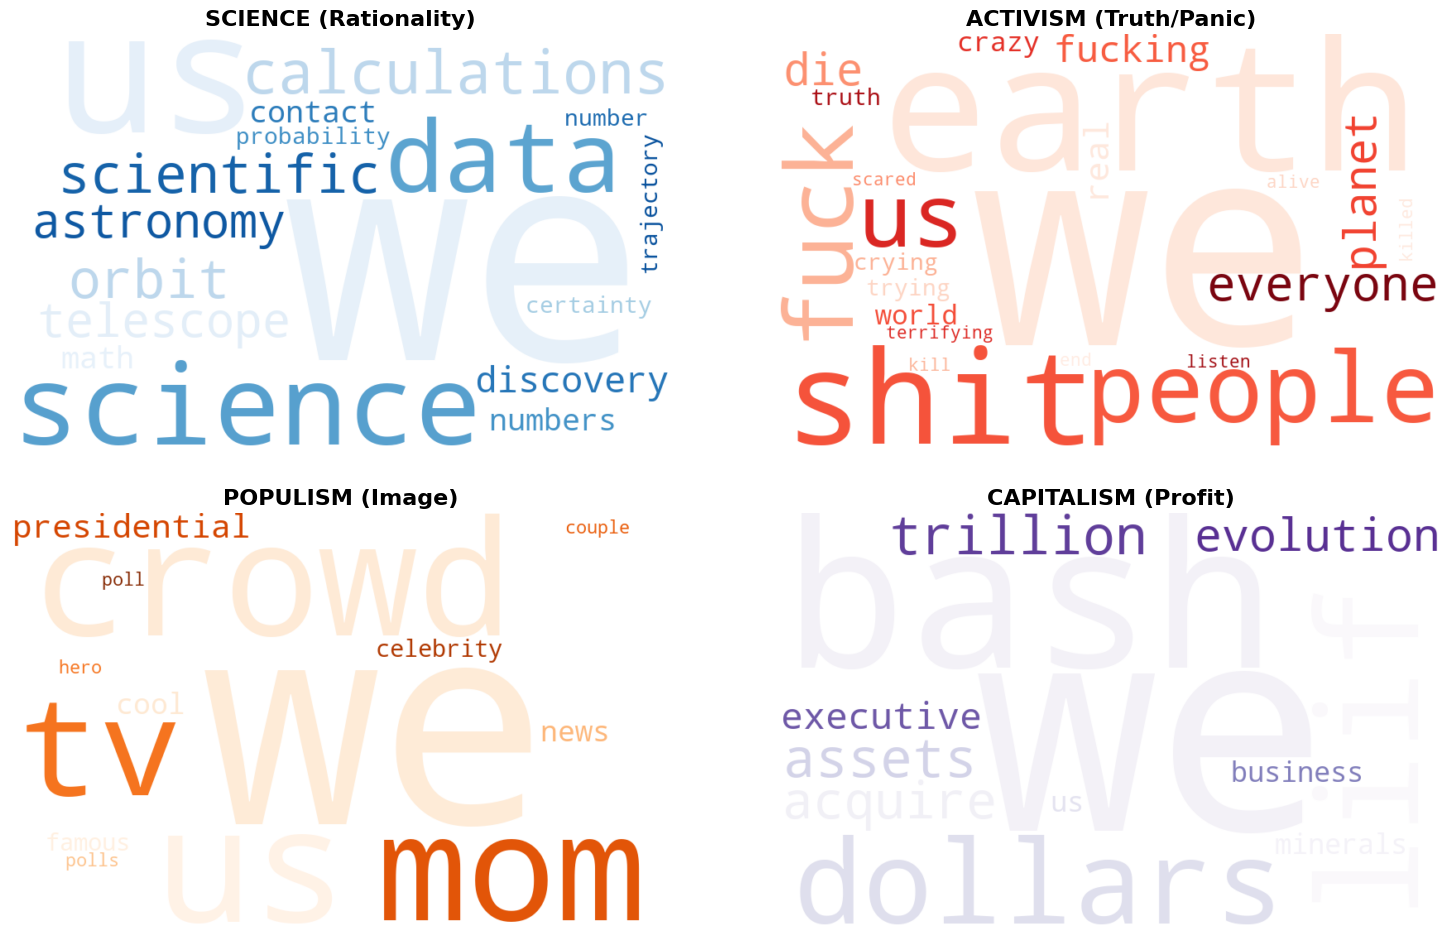

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import re
from wordcloud import WordCloud

# ==========================================
# 1. SETUP: GRUPPEN & KEYWORDS DEFINIEREN
# ==========================================
WORLDVIEW_GROUPS = {
    "SCIENCE (Rationality)": ["MINDY", "RANDALL", "DR. MINDY", "OGLETHORPE", "DR. OGLETHORPE"],
    # Wir stellen sicher, dass alle Varianten von Kate hier drin stehen
    "ACTIVISM (Truth/Panic)": ["KATE", "KATE DIBIASKY", "DIBIASKY", "YULE"],
    "POPULISM (Image)": ["ORLEAN", "PRESIDENT ORLEAN", "JANIE", "JASON", "JASON ORLEAN"],
    "CAPITALISM (Profit)": ["ISHERWELL", "PETER", "PETER ISHERWELL"]
}

KEYWORDS = {
    "SCIENCE (Rationality)": [
        "data", "math", "mathematics", "science", "scientific", "number", "numbers", 
        "peer-review", "trajectory", "telescope", "calculation", "calculations", 
        "accuracy", "fact", "facts", "physics", "sigma", "astronomy", 
        "discovery", "object", "orbit", "probability", "contact", "certainty", "we", "us"
    ],
    "ACTIVISM (Truth/Panic)": [
        "truth", "die", "dying", "kill", "killed", "planet", "earth", "world",
        "emergency", "scream", "shit", "fuck", "fucking", "real", "alive", 
        "terrifying", "stop", "end", "scared", "listen", "crying", "crazy",
        "people", "everyone", "trying", "joke", "nuts", "insane", "we", "us"
    ],
    "POPULISM (Image)": [
        "poll", "polls", "vote", "election", "trending", "celebrity", "media", 
        "rating", "ratings", "image", "crowd", "presidential", "mom", "hero", 
        "likes", "subscribers", "news", "tv", "famous", "cool", "love", "couple", "we", "us"
    ],
    "CAPITALISM (Profit)": [
        "dollar", "dollars", "trillion", "asset", "assets", "stock", "stocks", 
        "growth", "rich", "acquire", "evolution", "executive", "opportunity", 
        "liif", "bash", "buy", "buying", "mineral", "minerals", "gold", "job", "jobs",
        "business", "economy", "rights", "we", "us"
    ]
}

COLOR_MAPS = {
    "SCIENCE (Rationality)": "Blues",
    "ACTIVISM (Truth/Panic)": "Reds",
    "POPULISM (Image)": "Oranges",
    "CAPITALISM (Profit)": "Purples"
}

# ==========================================
# 2. NEU-PARSING (Einlesen erzwingen!)
# ==========================================
file_path = 'dont_lookup/Dont_Look_Up.txt' # Pfad ggf. anpassen

def force_reparse(path):
    print(f"Lese Datei neu ein: {path} ...")
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    # Leere Container erstellen
    texts = {key: [] for key in WORLDVIEW_GROUPS.keys()}
    
    # Alias-Map bauen
    alias_map = {}
    for group, aliases in WORLDVIEW_GROUPS.items():
        for alias in aliases:
            alias_map[alias] = group

    current_group = None

    for line in lines:
        text = line.strip()
        if not text: continue
        
        # Check: Ist es ein Name?
        found_group = None
        for alias, group in alias_map.items():
            # Exakter Start-Check
            if text.upper().startswith(alias.upper()) and len(text) < 30:
                found_group = group
                break
        
        if found_group:
            current_group = found_group
        elif current_group:
            # Text sammeln (ohne Regieanweisungen)
            if not (text.startswith("INT.") or text.startswith("EXT.") or text.startswith("CUT") or text.startswith("(")):
                 texts[current_group].append(text)
    
    # Zusammenfügen
    return {k: " ".join(v) for k, v in texts.items()}

# HIER WIRD NEU GELADEN:
grouped_text = force_reparse(file_path)

# CHECK: Haben wir jetzt Text?
print("\n--- STATUS CHECK ---")
for group, content in grouped_text.items():
    print(f"{group}: {len(content)} Zeichen gefunden.")
    
if len(grouped_text["ACTIVISM (Truth/Panic)"]) < 100:
    print("ALARM: Activism ist immer noch leer! Prüfe die Schreibweise 'KATE' im Textfile.")
else:
    print("Erfolg: Activism hat Text!")

# ==========================================
# 3. PLOTTEN
# ==========================================
def count_exact_keywords_robust(text, target_keywords):
    text_lower = text.lower()
    tokens = re.findall(r"\b\w+\b", text_lower)
    counts = {k: 0 for k in target_keywords}
    for t in tokens:
        if t in target_keywords:
            counts[t] += 1
    return {k: v for k, v in counts.items() if v > 0}

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, (group_name, text) in enumerate(grouped_text.items()):
    ax = axes[i]
    colormap = COLOR_MAPS.get(group_name, "Greys")
    target_keys = KEYWORDS.get(group_name, [])
    
    # Zählen
    frequencies = count_exact_keywords_robust(text, target_keys)
    
    if frequencies:
        wc = WordCloud(
            background_color="white",
            width=800, height=500,
            colormap=colormap,
            random_state=42,
            max_words=50,
            prefer_horizontal=0.9
        ).generate_from_frequencies(frequencies)
        
        image_array = np.array(wc.to_image())
        ax.imshow(image_array, interpolation="bilinear")
    else:
        ax.text(0.5, 0.5, "LEER", ha='center', va='center', fontsize=20, color='red')
    
    ax.set_title(group_name, fontsize=16, fontweight="bold")
    ax.axis("off")
    
    # Rahmen
    cmap = plt.get_cmap(colormap)
    spine_color = cmap(0.9) 
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color(spine_color)
        spine.set_linewidth(2)

plt.tight_layout(pad=3.0, h_pad=3.0, w_pad=2.0)
plt.savefig("Cloud.png", dpi=300, bbox_inches='tight')
plt.show()

Lade Sprachmodell (das kann kurz dauern)...
Lese Datei: dont_lookup/Dont_Look_Up.txt ...
Berechne semantische Distanz (via scikit-learn)...
Scanne Text nach Keywords...

--- KOSINUS-ÄHNLICHKEIT (Ideologische Distanz) ---
                        SCIENCE (Rationality)  ACTIVISM (Truth/Panic)  \
SCIENCE (Rationality)                1.000000                0.396361   
ACTIVISM (Truth/Panic)               0.396361                1.000000   
POPULISM (Image)                     0.505560                0.644108   
CAPITALISM (Profit)                  0.630820                0.422815   

                        POPULISM (Image)  CAPITALISM (Profit)  
SCIENCE (Rationality)           0.505560             0.630820  
ACTIVISM (Truth/Panic)          0.644108             0.422815  
POPULISM (Image)                1.000000             0.532757  
CAPITALISM (Profit)             0.532757             1.000000  


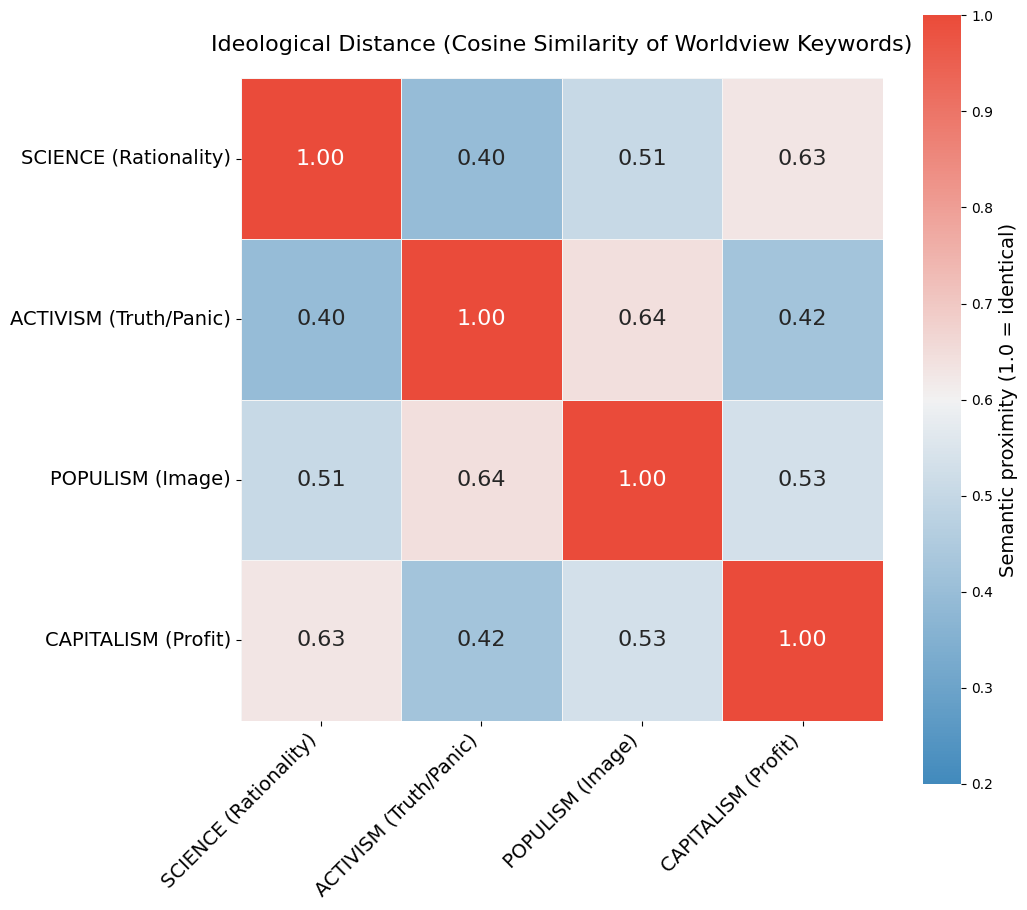

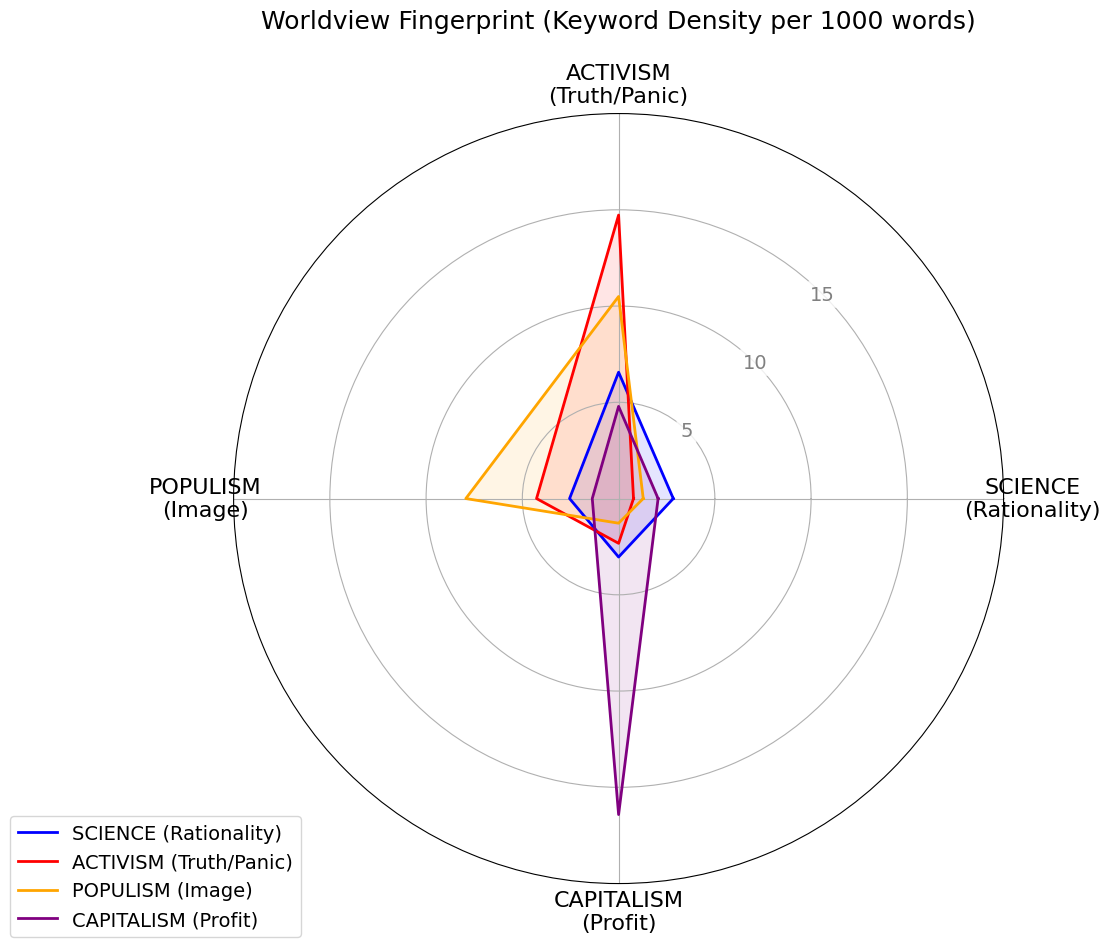

In [10]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from math import pi
from sklearn.metrics.pairwise import cosine_similarity

# ==========================================
# 1. SETUP & MODEL LOADING
# ==========================================
print("Lade Sprachmodell (das kann kurz dauern)...")
try:
    # Wir brauchen das Medium-Modell für Vektoren (md)
    nlp = spacy.load("en_core_web_md")
except OSError:
    print("FEHLER: Bitte lade das Modell erst herunter:")
    print("Run: python -m spacy download en_core_web_md")
    exit()

# DEFINITION DER 4 WELTBILD-GRUPPEN
WORLDVIEW_GROUPS = {
    "SCIENCE (Rationality)": ["MINDY", "RANDALL", "DR. MINDY", "OGLETHORPE", "DR. OGLETHORPE"],
    "ACTIVISM (Truth/Panic)": ["KATE", "KATE DIBIASKY", "DIBIASKY", "YULE"],
    "POPULISM (Image)": ["ORLEAN", "PRESIDENT ORLEAN", "JANIE", "JASON", "JASON ORLEAN"],
    "CAPITALISM (Profit)": ["ISHERWELL", "PETER", "PETER ISHERWELL"]
}

# KEYWORDS (Deine optimierte STRICT-Liste)
KEYWORDS = {
    "SCIENCE (Rationality)": [
        "data", "math", "mathematics", "science", "scientific", "number", "numbers", 
        "peer-review", "trajectory", "telescope", "calculations", "accuracy", 
        "fact", "facts", "physics", "sigma", "orbit", "probability", "certainty"
    ],
    "ACTIVISM (Truth/Panic)": [
        "truth", "die", "dying", "kill", "killed", "planet", "earth", 
        "emergency", "scream", "shit", "fuck", "fucking", "real", "alive", 
        "terrifying", "stop", "end", "scared", "crying", "insane"
    ],
    "POPULISM (Image)": [
        "poll", "polls", "vote", "election", "trending", "celebrity", "media", 
        "rating", "ratings", "image", "crowd", "presidential", "mom", "hero", 
        "likes", "subscribers", "news", "tv", "famous"
    ],
    "CAPITALISM (Profit)": [
        "dollar", "dollars", "trillion", "asset", "assets", "stock", "stocks", 
        "growth", "rich", "acquire", "evolution", "executive", "opportunity", 
        "liif", "bash", "buy", "buying", "mineral", "minerals", "gold"
    ]
}

# ==========================================
# 2. DATA PARSING
# ==========================================
def parse_screenplay_grouped(file_path):
    print(f"Lese Datei: {file_path} ...")
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    group_texts = {key: [] for key in WORLDVIEW_GROUPS.keys()}
    current_group = None
    
    alias_to_group = {}
    for group, aliases in WORLDVIEW_GROUPS.items():
        for alias in aliases:
            alias_to_group[alias] = group

    for line in lines:
        text = line.strip()
        if not text: continue

        found_group = None
        for alias, group in alias_to_group.items():
            if text.upper().startswith(alias.upper()) and len(text) < 30:
                found_group = group
                break
        
        if found_group:
            current_group = found_group
        elif current_group:
            if not (text.startswith("INT.") or text.startswith("EXT.") or text.startswith("CUT") or text.startswith("(")):
                 group_texts[current_group].append(text)

    return {k: " ".join(v) for k, v in group_texts.items()}

# ==========================================
# 3. ANALYSE (OPTIMIERT: Concept Similarity)
# ==========================================
def analyze_worldviews(text_data):
    results_keywords = {}
    
    # --- TEIL A: KOSINUS-ÄHNLICHKEIT DER IDEOLOGIEN ---

    print("Berechne semantische Distanz (via scikit-learn)...")
    
    groups = list(KEYWORDS.keys())
    sim_matrix = pd.DataFrame(index=groups, columns=groups, dtype=float)
    
    # Vektoren erstellen
    vectors = []
    for group in groups:
        word_list = KEYWORDS[group]
        concept_text = " ".join(word_list)
        # .vector gibt uns das reine NumPy-Array zurück
        # .reshape(1, -1) ist nötig, weil sklearn 2D-Arrays erwartet
        vec = nlp(concept_text).vector.reshape(1, -1)
        vectors.append(vec)
    
    # Matrix füllen mit sklearn
    for i, g1 in enumerate(groups):
        for j, g2 in enumerate(groups):
            # Hier nutzen wir jetzt explizit sklearn
            sim = cosine_similarity(vectors[i], vectors[j])[0][0]
            sim_matrix.loc[g1, g2] = sim

    # --- TEIL B: DENSITY SCAN ---
    print("Scanne Text nach Keywords...")
    docs = {}
    for group, text in text_data.items():
        if len(text) == 0: continue
        docs[group] = nlp(text[:200000]) 

    for group, doc in docs.items():
        counts = {k: 0 for k in KEYWORDS.keys()}
        
        # Robustere Tokenisierung (keine Satzzeichen)
        tokens = [t.lemma_.lower() for t in doc if not t.is_punct and not t.is_space]
        total_words = len(tokens)
        
        if total_words == 0: continue

        for t in tokens:
            for category, word_list in KEYWORDS.items():
                if t in word_list:
                    counts[category] += 1
        
        results_keywords[group] = {k: (v / total_words) * 1000 for k, v in counts.items()}

    return sim_matrix, results_keywords

# ==========================================
# 4. VISUALISIERUNG 
# ==========================================
def plot_results(sim_matrix, keyword_data):
    
    # --- PLOT 1: HEATMAP (Ideological Distance) ---
    plt.figure(figsize=(10, 9)) # Etwas höher für die Labels
    
    # EINE SCHÖNERE FARBPALETTE ERSTELLEN
    # Von kühlem Stahlblau (240) zu warmem Ziegelrot (15)
    # as_cmap=True erstellt eine stufenlose Farbskala
    custom_cmap = sns.diverging_palette(240, 15, s=80, l=55, n=9, as_cmap=True, center="light")

    ax = sns.heatmap(
        sim_matrix, 
        annot=True, 
        cmap=custom_cmap, # Unsere neue Palette
        vmin=0.2, vmax=1.0, # Skala für bessere Kontraste
        fmt=".2f",
        square=True,         # Quadratische Zellen 
        linewidths=.5,       # Feine Trennlinien
        linecolor='whitesmoke',
        annot_kws={"size": 16}, # Zahlen etwas größer
        cbar_kws={'label': 'Semantic proximity (1.0 = identical)'} # Skala beschriften
    )
    
    plt.title("Ideological Distance (Cosine Similarity of Worldview Keywords)", fontsize=16, pad=20)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()

    ax.tick_params(labelsize=14)
    cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(14)
    plt.savefig("Heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()

# --- PLOT 2: RADAR CHART (Das Weltbild) ---
    
    # 1. Daten vorbereiten
    original_labels = list(KEYWORDS.keys())
    display_labels = [label.replace(" (", "\n(") for label in original_labels]
    num_vars = len(original_labels)
    
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1] 
    
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)

    # 1. X-Achse (Außen) wie gehabt
    plt.xticks(angles[:-1], display_labels, color='black', size=16)
    ax.tick_params(axis='x', pad=10)

    # 2. Y-Achse: Standard-Beschriftung AUSSCHALTEN
    # Wir lassen die Grid-Linien da, aber entfernen die Labels
    plt.yticks([5, 10, 15], labels=[], color="grey") # labels=[] macht den Text leer
    plt.ylim(0, 20)

    # 3. Y-Achse: Zahlen MANUELL setzen
    # Wir wählen einen Winkel (z.B. 45 Grad), wo Platz ist
    label_angle_deg = 45
    label_angle_rad = np.deg2rad(label_angle_deg) # Umrechnung in Bogenmaß für den Plot

    # Loop um die Zahlen 5, 10, 15 manuell zu schreiben
    for val in [5, 10, 15]:
        ax.text(
            label_angle_rad,  # Winkel (X-Pos)
            val,              # Radius (Y-Pos)
            str(val),         # Text
            color="grey",
            size=14,
            ha='center',      # Horizontal zentriert auf der Linie
            va='center',      # Vertikal zentriert (kein Verrutschen mehr!)
            # Optional: Weißer Hintergrund, damit die Linie nicht durch die Zahl geht
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2', alpha=0.8)
        )

    # --- Plotten der Daten ---
    colors = ['blue', 'red', 'orange', 'purple']

    if not keyword_data:
        print("Keine Keyword-Daten zum Plotten gefunden.")
    else:
        for i, (group, data) in enumerate(keyword_data.items()):
            values = [data.get(l, 0) for l in original_labels]
            values += values[:1] 
        
            ax.plot(angles, values, linewidth=2, linestyle='solid', label=group, color=colors[i])
            ax.fill(angles, values, color=colors[i], alpha=0.1)

    plt.title("Worldview Fingerprint (Keyword Density per 1000 words)", size=18, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=14)
    #plt.legend(title='', loc='upper right', fontsize=16)

    plt.savefig("Chart.png", dpi=300, bbox_inches='tight')
    plt.show()

# ==========================================
# MAIN EXECUTION
# ==========================================
file_path = 'dont_lookup/Dont_Look_Up.txt' 

try:
    grouped_text = parse_screenplay_grouped(file_path)
    sim_matrix, keyword_results = analyze_worldviews(grouped_text)
    
    print("\n--- KOSINUS-ÄHNLICHKEIT (Ideologische Distanz) ---")
    print(sim_matrix)
    
    # plot_results aufrufen
    plot_results(sim_matrix, keyword_results)

except FileNotFoundError:
    print(f"Datei nicht gefunden: {file_path}")